This file is based on "4.27- Link input with activations.ipynb", with updated data structure (different list structures -> list of tuples). There are also more data that are useful for making visualizations

1. Load libraries

In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm

# Use IoU instead
# import re
from scipy.spatial.distance import cdist
from skimage.transform import resize

d:\zsh\graduation\grad_env_take_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###### 2. Decide the procedure by grouping the different columns together

For cityscapes and synthia separately (and then concatenate):

* name, image_path, dataset

* label_path:
    * first get labels (in class format)
        * for synthia, need to transform to class format specifically
            * for calculating similarity
        * also from class to color as well, because use the color of cityscapes
            * for saving the label and getting the label path
        * get the saved path and save it in a list
    
* similar_image_paths，similar_IoU_score (Note: called IoU_score originally): finding the most similar masks from another dataset
* Generate from os list of images:
    * class distribution
        * (other_ratio, road_ratio, sidewalk_ratio, vegetation_ratio, sky_ratio, car_ratio)
    * embedding of input (originally: tsne_1, tsne_2)
        simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
        and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)
* bottleneck_activations_embedding, prediction_path, and performance
    * save output locally, and then add path (prediction_path)
    * performance: (other_IoU, road_IoU, sidewalk_IoU, vegetation_IoU, sky_IoU, car_IoU)
        **How do you get the IoU per class (check original paper)**

**Make sure that the column names are the same as current！！！**

**Remember to also save id**

# name, image_path, dataset

In [ ]:
# path of the image folders for the model
image_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"
image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image"

# path of image folders for displaying in the system

start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_img_path_cityscapes = os.path.relpath(image_path_cityscapes, start)
relative_img_path_synthia = os.path.relpath(image_path_synthia, start)


In [2]:
sample_number = 500

In [17]:
cityscapes_names= os.listdir(image_path_cityscapes)
random.seed(55)
cityscapes_names_sample = random.sample(cityscapes_names,sample_number)

synthia_names = os.listdir(image_path_synthia)
# randomly select 100 images to load in to numpy array
random.seed(55)
synthia_names_sample = random.sample(synthia_names,sample_number)

In [18]:
# Cityscapes
cityscapes_initial_info = []
cityscapes_img_sample = []

for name in cityscapes_names_sample:
    image = Image.open(image_path_cityscapes+"\\"+name).convert("RGB")
    image_path = relative_img_path_cityscapes+"\\"+name
    
    cityscapes_img_sample.append(np.array(image))
    cityscapes_initial_info.append((name,image_path,"Cityscapes"))

cityscapes_initial_info = np.array(cityscapes_initial_info)

In [19]:
cityscapes_initial_info[:5]

array([['14.jpeg', 'dataset\\original_cityscapes_inputs\\14.jpeg',
        'Cityscapes'],
       ['87.jpeg', 'dataset\\original_cityscapes_inputs\\87.jpeg',
        'Cityscapes'],
       ['189.jpeg', 'dataset\\original_cityscapes_inputs\\189.jpeg',
        'Cityscapes'],
       ['167.jpeg', 'dataset\\original_cityscapes_inputs\\167.jpeg',
        'Cityscapes'],
       ['439.jpeg', 'dataset\\original_cityscapes_inputs\\439.jpeg',
        'Cityscapes']], dtype='<U43')

In [20]:
# synthia

synthia_initial_info = []
synthia_img_sample = []

for name in synthia_names_sample:
    image = Image.open(image_path_synthia+"\\"+name).convert("RGB")
    image_path = relative_img_path_synthia+"\\"+name
    synthia_initial_info.append((name, image_path,"Synthia"))
    synthia_img_sample.append(np.array(image))

synthia_initial_info = np.array(synthia_initial_info)
synthia_img_sample = np.array(synthia_img_sample)

In [21]:
len(synthia_initial_info)

500

In [22]:
combined_initial_info = np.concatenate((cityscapes_initial_info,synthia_initial_info),axis=0)

In [23]:
df = pd.DataFrame(combined_initial_info,columns = ["name", "image_path","dataset"])

In [24]:
df

,name,image_path,dataset
0,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,Cityscapes
1,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,Cityscapes
2,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,Cityscapes
3,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,Cityscapes
4,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,Cityscapes
...,...,...,...
995,0005718.png,dataset\SYNTHIA_256\image\0005718.png,Synthia
996,0000233.png,dataset\SYNTHIA_256\image\0000233.png,Synthia
997,0007887.png,dataset\SYNTHIA_256\image\0007887.png,Synthia
998,0003190.png,dataset\SYNTHIA_256\image\0003190.png,Synthia


# Synthia color transformation code (for later use)

In [25]:
synthia_colors = [[  0,   0,   0], # void
         [70,130, 180], # sky
         [70,70,70], # building
        [128, 64, 128], # road
        [244, 35, 232], # sidewalk
         [64,64,128], # fense
         [107,142,35], # vegetation	
        [153, 153, 153], # pole
        [0, 0, 142], # car
        [220, 220, 0],  # traffic sign
        [220, 20, 60], # pedestrian
        [119, 11, 32], # bicycle
        [0, 0, 230], # motorcycle
        [250,170,160], # parking-slot
        [128,64,64], # road-work
        [250,170,30], # traffic light
        [152, 251, 152], # terrain
        [255, 0, 0], # rider
        [0, 0, 70], # truck
        [0, 60, 100], # bus
        [0, 80, 100], # train
        [102, 102, 156]# wall, lanemarking
    ]


category_map = {
    0: 0,
    1: 4,
    2: 0,
    3: 1,
    4: 2,
    5: 0,
    6: 3,
    7: 0,
    8: 5,
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 0,
    21: 0}

In [26]:
# color to class
def color_to_class(label):
    # create new empty mask
    mask = np.zeros(shape=(label.shape[0], label.shape[1]), dtype = np.int32)
    # iterate through two dimensions
    for row in range(label.shape[0]):
        for col in range(label.shape[1]):
            a = label[row, col,:]
            # distance between this pixel and the original pixel
            d = cdist(np.array([a]),np.array(synthia_colors))
            idx = np.argmin(d)
            new_idx = category_map[idx]
            mask[row, col] = new_idx
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1]))
    return mask

In [27]:
# class to color: useful for displaying the similar images later
colors = [[  0,   0,   0],
          [128, 64, 128],# road
          [244, 35, 232], # sidewalk
          [107, 142, 35],# vegetation
          [70, 130, 180], # sky
          [0, 0, 142], # car
         ]

def class_to_color(labels):
    label_colors = np.zeros((256,256,3))
    
    for i,row in enumerate(labels):
        for j,pixel in enumerate(row):
            label_colors[i,j] = colors[pixel]
    
    return label_colors.astype(int)  # make each pixel value an integer to visualize it better

# label_path

Cityscapes labels

In [28]:
# relative paths for cityscapes
cityscpaes_save_labels_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_labels_sample"
cityscapes_label_folder_relative = os.path.relpath(cityscpaes_save_labels_path, start)

**For now: still use the sample of labels. Possibly changing to something else later on**

In [29]:
# labels of cityscapes
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)
    
cityscapes_labels = np.array(Y_test)

Generate and save labels for the subset for displaying in the VA system

In [30]:
cityscapes_labels_sample= []
cityscapes_label_path_sample = []

for name in cityscapes_names_sample:
    ind = int(name.split('.')[0])
    label = cityscapes_labels[ind]
    label_path = cityscapes_label_folder_relative+"\\"+name
    
    cityscapes_labels_sample.append(label)
    cityscapes_label_path_sample.append(label_path)

cityscapes_labels_sample = np.array(cityscapes_labels_sample)
cityscapes_label_path_sample = np.array(cityscapes_label_path_sample)

In [31]:
for i in range(sample_number):
    name = cityscapes_names_sample[i]
    label = cityscapes_labels_sample[i]
    label_color = class_to_color(label)
    label_image = Image.fromarray(label_color.astype(np.uint8))
    label_image.save(cityscpaes_save_labels_path+"\\"+name)

KeyboardInterrupt: 

In [ ]:
cityscapes_label_path_sample.shape

Synthia labels

In [ ]:
synthia_label_original_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\label-rgb"
synthia_save_labels_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\\new_labels"
synthia_label_folder_relative = os.path.relpath(synthia_save_labels_path, start)

In [42]:
# def transform_masks_synthia(labels):
#     masks = []
#     for label in labels:
#         mask = color_to_class(label)
#         masks.append(mask)
#     masks = np.array(masks)

#     return masks

Note: comment out the corresponding lines if loading the synthia_labels_sample.pkl

In [ ]:
# this usually takes a long time
synthia_labels_sample= []
synthia_label_path_sample = []

for name in synthia_names_sample:
    original_label_rgb = Image.open(synthia_label_original_folder+"\\"+name).convert("RGB")
    original_label_rgb = np.array(original_label_rgb)
    label = color_to_class(original_label_rgb)
    resized_label_rgb = class_to_color(label)
    label_path =synthia_label_folder_relative+"\\"+name
    resized_label_rgb = Image.fromarray(resized_label_rgb.astype(np.uint8))
    
#     save the new labels
    resized_label_rgb.save(synthia_save_labels_path+"\\"+name)
    
    synthia_labels_sample.append(label)
    synthia_label_path_sample.append(label_path)

synthia_labels_sample = np.array(synthia_labels_sample)
synthia_label_path_sample = np.array(synthia_label_path_sample)

In [32]:
len(synthia_label_path_sample)

500

save the synthia masks in a pickle to save effort

In [32]:
# with open('synthia_labels_sample.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(synthia_labels_sample, file)

with open('synthia_labels_sample.pkl', 'rb') as f:
    synthia_labels_sample = pickle.load(f)

In [26]:
synthia_labels_sample.shape

(500, 256, 256)

Combine cityscapes_label_path_sample and synthia_label_path_sample

In [34]:
label_path_sample = np.concatenate((cityscapes_label_path_sample,synthia_label_path_sample),axis = 0)

In [35]:
df["label_path"] = label_path_sample

In [36]:
df.iloc[495:505]

,name,image_path,dataset,label_path
495,252.jpeg,dataset\original_cityscapes_inputs\252.jpeg,Cityscapes,dataset\cityscapes_labels_sample\252.jpeg
496,467.jpeg,dataset\original_cityscapes_inputs\467.jpeg,Cityscapes,dataset\cityscapes_labels_sample\467.jpeg
497,406.jpeg,dataset\original_cityscapes_inputs\406.jpeg,Cityscapes,dataset\cityscapes_labels_sample\406.jpeg
498,411.jpeg,dataset\original_cityscapes_inputs\411.jpeg,Cityscapes,dataset\cityscapes_labels_sample\411.jpeg
499,210.jpeg,dataset\original_cityscapes_inputs\210.jpeg,Cityscapes,dataset\cityscapes_labels_sample\210.jpeg
500,0001480.png,dataset\SYNTHIA_256\image\0001480.png,Synthia,dataset\SYNTHIA_256\new_labels\0001480.png
501,0003215.png,dataset\SYNTHIA_256\image\0003215.png,Synthia,dataset\SYNTHIA_256\new_labels\0003215.png
502,0002457.png,dataset\SYNTHIA_256\image\0002457.png,Synthia,dataset\SYNTHIA_256\new_labels\0002457.png
503,0004959.png,dataset\SYNTHIA_256\image\0004959.png,Synthia,dataset\SYNTHIA_256\new_labels\0004959.png
504,0001305.png,dataset\SYNTHIA_256\image\0001305.png,Synthia,dataset\SYNTHIA_256\new_labels\0001305.png


# similar_image_paths，similar_IoU_score 
(Note: called IoU_score originally): finding the most similar masks from another dataset

In [37]:
def most_similar_mask(instance, data,mode = "IoU"):
#     nodes = np.asarray(nodes)
    # Euclidean distance calculation
    if mode == "IoU":
        iou_list = []
        for new_instance in data:
#             the original IoU methods were not good because when both class is 0, the intersection won't count it
#             intersection = np.logical_and(instance, new_instance)
#             union = np.logical_or(instance, new_instance)
            intersection = len(np.where(instance == new_instance)[0])
            union = instance.shape[0]*instance.shape[1]
#             print(intersection)
#             print(union)
            iou_score = intersection / union
            iou_list.append(iou_score)
        iou_arr = np.array(iou_list)
        best_index = np.argmax(iou_arr)
        best_score = iou_arr[best_index]
    
    return best_index, best_score

In [38]:
cityscapes_similar_image_paths = []
cityscapes_similar_scores = []

for label in cityscapes_labels_sample:
    image_index_synthia,similar_score = most_similar_mask(label,synthia_labels_sample)
    similar_image_path = synthia_initial_info[image_index_synthia][1]
    
    cityscapes_similar_image_paths.append(similar_image_path)
    cityscapes_similar_scores.append(similar_score)

cityscapes_similar_image_paths = np.array(cityscapes_similar_image_paths)
cityscapes_similar_scores = np.array(cityscapes_similar_scores)

In [39]:
synthia_similar_image_paths = []
synthia_similar_scores = []

for label in synthia_labels_sample:
    image_index_cityscapes,similar_score = most_similar_mask(label,cityscapes_labels_sample)
    similar_image_path = cityscapes_initial_info[image_index_cityscapes][1]
    
    synthia_similar_image_paths.append(similar_image_path)
    synthia_similar_scores.append(similar_score)

synthia_similar_image_paths = np.array(synthia_similar_image_paths)
synthia_similar_scores = np.array(synthia_similar_scores)

In [40]:
similar_image_paths =  np.concatenate((cityscapes_similar_image_paths,synthia_similar_image_paths),axis = 0)
similar_scores = np.concatenate((cityscapes_similar_scores,synthia_similar_scores),axis = 0)

In [41]:
df["similar_image_paths"] = similar_image_paths
df["similar_IoU_score"]=similar_scores

In [42]:
df.iloc[495:505]

,name,image_path,dataset,label_path,similar_image_paths,similar_IoU_score
495,252.jpeg,dataset\original_cityscapes_inputs\252.jpeg,Cityscapes,dataset\cityscapes_labels_sample\252.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.641891
496,467.jpeg,dataset\original_cityscapes_inputs\467.jpeg,Cityscapes,dataset\cityscapes_labels_sample\467.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.538345
497,406.jpeg,dataset\original_cityscapes_inputs\406.jpeg,Cityscapes,dataset\cityscapes_labels_sample\406.jpeg,dataset\SYNTHIA_256\image\0005321.png,0.556641
498,411.jpeg,dataset\original_cityscapes_inputs\411.jpeg,Cityscapes,dataset\cityscapes_labels_sample\411.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.571030
499,210.jpeg,dataset\original_cityscapes_inputs\210.jpeg,Cityscapes,dataset\cityscapes_labels_sample\210.jpeg,dataset\SYNTHIA_256\image\0000453.png,0.613754
500,0001480.png,dataset\SYNTHIA_256\image\0001480.png,Synthia,dataset\SYNTHIA_256\new_labels\0001480.png,dataset\original_cityscapes_inputs\463.jpeg,0.449783
501,0003215.png,dataset\SYNTHIA_256\image\0003215.png,Synthia,dataset\SYNTHIA_256\new_labels\0003215.png,dataset\original_cityscapes_inputs\188.jpeg,0.492340
502,0002457.png,dataset\SYNTHIA_256\image\0002457.png,Synthia,dataset\SYNTHIA_256\new_labels\0002457.png,dataset\original_cityscapes_inputs\147.jpeg,0.487686
503,0004959.png,dataset\SYNTHIA_256\image\0004959.png,Synthia,dataset\SYNTHIA_256\new_labels\0004959.png,dataset\original_cityscapes_inputs\61.jpeg,0.600769
504,0001305.png,dataset\SYNTHIA_256\image\0001305.png,Synthia,dataset\SYNTHIA_256\new_labels\0001305.png,dataset\original_cityscapes_inputs\83.jpeg,0.539551


In [92]:
# df.to_csv("system_df_full.csv",index=True)

# generate from list of images and labels

* class distribution
    * (other_ratio, road_ratio, sidewalk_ratio, vegetation_ratio, sky_ratio, car_ratio)
* embedding of input (originally: tsne_1, tsne_2)
    * simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
    * and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)

Load images to data loader

In [12]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [35]:
repo_path = "D:\zsh\graduation\\Graduation-project-domain-shift-image-2-image"
# cityscapes_label_path = "dataset\\cityscapes_labels_100"
cityscapes_images = []
cityscapes_labels = []
synthia_images = []
synthia_labels = []

for index,path in enumerate(df["image_path"]):
    full_path = os.path.join(repo_path,path)
    dataset = df["dataset"].iloc[index]
    # parse to get the name of image
    name = os.path.split(path)[1]
    label_index = int(name.split(".")[0])
    if dataset == "Cityscapes":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = Y_test[label_index]
        label = np.array(label)
        cityscapes_images.append(img)
        cityscapes_labels.append(label)
    elif dataset == "Synthia":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = synthia_labels_sample[index-sample_number]
        label = np.array(label)
        synthia_images.append(img)
        synthia_labels.append(label)
    

In [36]:
cityscapes_images = np.array(cityscapes_images)
cityscapes_labels = np.array(cityscapes_labels)
synthia_images = np.array(synthia_images)
synthia_labels = np.array(synthia_labels)

print(synthia_images.shape)
print(synthia_images.shape)


(500, 256, 256, 3)
(500, 256, 256, 3)


In [37]:
# load to Dataset class and DataLoader
batch_size = 1
cityscapes_dataset = CityscapesDataset(cityscapes_images, cityscapes_labels,noise_level=0)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=batch_size)

synthia_dataset = CityscapesDataset(synthia_images, synthia_labels,noise_level=0)
synthia_loader = DataLoader(synthia_dataset, batch_size=batch_size)

**class distribution**

In [47]:
def get_class_distribution(labels):
    class_dist = []
    for label in labels:
        class_for_label = []
        for i in range(6):
            element_count = np.count_nonzero(label==i)
            class_for_label.append(element_count/(256*256))
        class_dist.append(class_for_label)
        class_for_label= class_for_label# change to another size if the image size is changed
    class_dist = np.array(class_dist)
    return class_dist

In [48]:
cityscpaes_class_dist = get_class_distribution(cityscapes_labels)
# synthia_labels
synthia_class_dist = get_class_distribution(synthia_labels)

In [49]:
print(cityscpaes_class_dist.shape)
print(synthia_class_dist.shape)

(500, 6)
(500, 6)


In [50]:
class_dist = np.concatenate((cityscpaes_class_dist,synthia_class_dist),axis=0)

In [51]:
class_dist_df = pd.DataFrame(class_dist,columns=["other_ratio","road_ratio","sidewalk_ratio","vegetation_ratio","sky_ratio","car_ratio"])
class_dist_df.head()

,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,sky_ratio,car_ratio
0,0.268173,0.380219,0.054855,0.259460,0.026566,0.010727
1,0.390427,0.322311,0.000000,0.128143,0.004623,0.154495
2,0.615875,0.264603,0.010590,0.037872,0.023697,0.047363
3,0.235931,0.296295,0.021698,0.421646,0.023544,0.000885
4,0.501968,0.312622,0.026047,0.157547,0.000031,0.001785


In [52]:
df_full = pd.concat((df,class_dist_df),axis=1)

In [127]:
# df_full.to_csv("system_df_full.csv",index=True)

**embedding of input**

* simple dimensionality reduction (simple_tsne_1,simple_tsne_2)
* and also the embedding from classification model(meaningful_tsne_1,meaningful_tsne_1)

In [38]:
# simple dimensionality reduction
combined_images = np.concatenate((cityscapes_images,synthia_images),axis=0)

In [54]:
simple_combined_embedding =np.reshape(combined_images,(len(combined_images), 256*256*3))

pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(simple_combined_embedding)
print(np.sum(pca_50.explained_variance_ratio_))
tsne = TSNE()
simple_tsne_embedding = tsne.fit_transform(pca_embedding)

0.7041049841733005


In [130]:
simple_combined_embedding =np.reshape(combined_images,(len(combined_images), 256*256*3))
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(simple_combined_embedding)
print(np.sum(pca.explained_variance_ratio_))

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [55]:
cd D:\zsh\graduation\ViTs-vs-CNNs

D:\zsh\graduation\ViTs-vs-CNNs


In [56]:
import torch
import torch.nn as nn
import global_val

from models.ghost_bn import GhostBN2D_ADV
from models.advresnet_gbn_gelu import Affine
import models.advresnet_gbn_gelu as advres
from main_adv_res import EightBN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier_model = advres.__dict__["resnet50"](norm_layer = EightBN)
weights_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\advres50_gelu.pth"
weight_dict = torch.load(weights_path,map_location=device)["model"]

classifier_model.load_state_dict(weight_dict)

<All keys matched successfully>

In [57]:
cd D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter

D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter


In [58]:
def get_representation_for_image(image,label):
    # resize the image and transform it to tensor # [256,256,3] -> [224,224,3] 
    resized_image = resize(image, (224, 224,3))
    resized_image_tensor = torch.from_numpy(resized_image)
    resized_image_tensor = torch.permute(resized_image_tensor, (2, 0, 1))
    resized_image_tensor = resized_image_tensor[None,:] # [3,224,224] -> [1,3,224,224] (because model takes 4D input)
    
    # dictionary for the activations
    activations = {}

    def get_activations(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # use the output of (avgpool) layer because it is the same as the input of last layer
    h = classifier_model.avgpool.register_forward_hook(get_activations("input_last_layer"))

    classifier_model.eval()
    classifier_model.sing=True
    classifier_model.training=False
    out = classifier_model(resized_image_tensor.float(),label)
    
    # remove the hook
    h.remove()

    first_part_embedding = torch.flatten(activations["input_last_layer"][0])
    
    return first_part_embedding

In [59]:
embedding_list = []
for i, image in enumerate(combined_images): # i is not used, could remove the enumerate
    first_part_embedding = get_representation_for_image(image,"__") # y_label is never used, so just use replacement
    second_part_embedding = class_dist[i]
    embedding = np.concatenate((first_part_embedding.numpy(),np.array(second_part_embedding)),axis = 0)
    embedding_list.append(embedding)

In [60]:
embedding_arr = np.array(embedding_list)
pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(embedding_arr)
print(np.sum(pca_50.explained_variance_ratio_))
# pca = PCA(n_components=2)
tsne = TSNE()
meaningful_tsne_embedding = tsne.fit_transform(pca_embedding)

0.8084270322747914


In [ ]:
pca_2= PCA(n_components=2)
pca_embedding = pca_2.fit_transform(embedding_arr)

In [133]:
full_embedding = np.concatenate((simple_tsne_embedding,meaningful_tsne_embedding,pca_embedding),axis=1)

In [135]:
df_input_embedding = pd.DataFrame(full_embedding, columns=["simple_tsne_1","simple_tsne_2","meaningful_tsne_1","meaningful_tsne_2","pca_1","pca_2"])

In [138]:
df_input_embedding.head()

,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,-2.480539,19.337982,42.454220,2.037380,2151.868066,-6784.818953
1,1.876197,-29.772099,34.633064,-14.335748,5757.674332,769.960507
2,-18.913595,3.844004,19.672724,-28.158758,6453.862370,-1707.970197
3,-2.939423,3.061823,30.822628,-1.028680,-1342.652149,-1318.782118
4,-8.347136,24.559172,38.062389,12.353762,1053.077618,-12544.593856


In [137]:
df_full = pd.concat((df_full,df_input_embedding),axis = 1)
df_full.head()

,name,image_path,dataset,label_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,sidewalk_ratio,vegetation_ratio,...,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,simple_tsne_1,simple_tsne_2,meaningful_tsne_1,meaningful_tsne_2,pca_1,pca_2
0,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,Cityscapes,dataset\cityscapes_labels_sample\14.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.483337,0.268173,0.380219,0.054855,0.259460,...,-2.480539,19.337982,42.454220,2.037380,-2.480539,19.337982,42.454220,2.037380,2151.868066,-6784.818953
1,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,Cityscapes,dataset\cityscapes_labels_sample\87.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.518250,0.390427,0.322311,0.000000,0.128143,...,1.876197,-29.772099,34.633064,-14.335748,1.876197,-29.772099,34.633064,-14.335748,5757.674332,769.960507
2,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,Cityscapes,dataset\cityscapes_labels_sample\189.jpeg,dataset\SYNTHIA_256\image\0004751.png,0.679016,0.615875,0.264603,0.010590,0.037872,...,-18.913595,3.844004,19.672724,-28.158758,-18.913595,3.844004,19.672724,-28.158758,6453.862370,-1707.970197
3,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,Cityscapes,dataset\cityscapes_labels_sample\167.jpeg,dataset\SYNTHIA_256\image\0003061.png,0.516190,0.235931,0.296295,0.021698,0.421646,...,-2.939423,3.061823,30.822628,-1.028680,-2.939423,3.061823,30.822628,-1.028680,-1342.652149,-1318.782118
4,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,Cityscapes,dataset\cityscapes_labels_sample\439.jpeg,dataset\SYNTHIA_256\image\0004747.png,0.559937,0.501968,0.312622,0.026047,0.157547,...,-8.347136,24.559172,38.062389,12.353762,-8.347136,24.559172,38.062389,12.353762,1053.077618,-12544.593856


In [142]:
df_full.to_csv("system_df_v2.csv",index=True)

#  bottleneck_activations_embedding, prediction_path, and performance
* save output locally, and then add path (prediction_path)
* performance: (other_IoU, road_IoU, sidewalk_IoU, vegetation_IoU, sky_IoU, car_IoU)
    **How do you get the IoU per class (check original paper)**

Read the data (for updating the bottleneck activations)

In [3]:
# Warning: comment this out
df = pd.read_csv("system_df_v2.csv")

In [4]:
df.head()

,id,name,dataset,image_path,label_path,prediction_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,...,pca_1,pca_2,bottleneck_activations_embedding,overall_iou,other_iou,road_iou,sidewalk_iou,vegetation_iou,sky_iou,car_iou
0,0,14.jpeg,Cityscapes,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_sample\14.jpeg,dataset\cityscapes_predictions\14.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.483337,0.268173,0.380219,...,2151.868066,-6784.818953,"[[-14.129362106323242, -6.828981399536133], [2...",0.880295,0.719708,0.944721,0.695616,0.718850,0.862466,0.311558
1,1,87.jpeg,Cityscapes,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_sample\87.jpeg,dataset\cityscapes_predictions\87.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.518250,0.390427,0.322311,...,5757.674332,769.960507,"[[-14.147808074951172, -6.797077655792236], [2...",0.905487,0.788071,0.962711,0.000000,0.739955,0.164607,0.863164
2,2,189.jpeg,Cityscapes,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_sample\189.jpeg,dataset\cityscapes_predictions\189.jpeg,dataset\SYNTHIA_256\image\0004751.png,0.679016,0.615875,0.264603,...,6453.862370,-1707.970197,"[[-14.206705093383789, -6.70464563369751], [24...",0.849472,0.780169,0.925425,0.127430,0.278427,0.892169,0.811478
3,3,167.jpeg,Cityscapes,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_sample\167.jpeg,dataset\cityscapes_predictions\167.jpeg,dataset\SYNTHIA_256\image\0003061.png,0.516190,0.235931,0.296295,...,-1342.652149,-1318.782118,"[[-10.809883117675781, -14.634546279907227], [...",0.691772,0.462270,0.940231,0.192641,0.402005,0.920625,0.008711
4,4,439.jpeg,Cityscapes,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_sample\439.jpeg,dataset\cityscapes_predictions\439.jpeg,dataset\SYNTHIA_256\image\0004747.png,0.559937,0.501968,0.312622,...,1053.077618,-12544.593860,"[[-14.37430191040039, -6.38221549987793], [13....",0.738602,0.669778,0.695943,0.133251,0.536060,0.000000,0.033378


Load model

In [5]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [5]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"

device = torch.device('cpu')
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

In [6]:
def IoU_per_class(prediction,label):
    prediction = prediction.detach().numpy()
    label = label.detach().numpy()
    # Loop over each class
    iou_list = []
    # Flatten label and class arrays
    flat_prediction = prediction.flatten()
    flat_label = label.flatten()

    for i in range(6):
        
        # Calculate intersection and union
        intersection = np.sum((flat_prediction == i) & (flat_label == i))
        union = np.sum((flat_prediction == i) | (flat_label == i))

        # Calculate IoU
        iou = intersection / (union + 1e-12)

        # Store IoU value in dictionary
        iou_list.append(iou)
    
    # calculate overall IoU
    intersection = len(np.where(flat_prediction == flat_label)[0])
    union = len(flat_label)
    overall_iou = intersection / (union + 1e-12)
    
    return overall_iou,iou_list

In [39]:
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cityscapes_activations = []
cityscapes_overall_iou = []
cityscapes_iou_by_class =[]
cityscapes_predictions = []

for image,label in tqdm(cityscapes_loader):
    activation = {}
    h = model_.middle[5].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    prediction = torch.argmax(out, dim=1)
    h.remove()
    overall_iou,iou_list = IoU_per_class(prediction,label)
    cityscapes_overall_iou.append(overall_iou)
    cityscapes_iou_by_class.append(iou_list)
    prediction = prediction.detach().numpy()[0]
    cityscapes_predictions.append(prediction)
    instance_activation = activation["bottleneck"]
#     print(instance_activation.size())
    # need to reshape
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    cityscapes_activations.append(instance_activation_reshaped)
#     print(instance_activation_reshaped.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [10:26<00:00,  1.25s/it]


In [40]:
cityscapes_activations = np.array(cityscapes_activations)
cityscapes_overall_iou = np.array(cityscapes_overall_iou)
cityscapes_iou_by_class = np.array(cityscapes_iou_by_class)
cityscapes_predictions = np.array(cityscapes_predictions)

In [41]:
cityscapes_predictions.shape

(500, 256, 256)

In [42]:
synthia_activations = []
synthia_overall_iou = []
synthia_iou_by_class =[]
synthia_predictions =[]
for image,label in tqdm(synthia_loader):
    activation = {}
    h = model_.middle[3].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    prediction = torch.argmax(out, dim=1)
    h.remove()
    overall_iou,iou_list = IoU_per_class(prediction,label)
    synthia_overall_iou.append(overall_iou)
    synthia_iou_by_class.append(iou_list)
    prediction = prediction.detach().numpy()[0]
    synthia_predictions.append(prediction)
    instance_activation = activation["bottleneck"]
#     print(instance_activation.size())
    # need to reshape
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    synthia_activations.append(instance_activation_reshaped)

synthia_activations = np.array(synthia_activations)
synthia_overall_iou = np.array(synthia_overall_iou)
synthia_iou_by_class = np.array(synthia_iou_by_class)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [10:35<00:00,  1.27s/it]


In [43]:
synthia_activations[:5]

array([[[ -394.57816  ,  -477.52103  ,  -604.128    , ...,
          -421.5565   ,  -624.01764  ,  -299.06595  ],
        [ -220.96764  ,  -185.4941   ,    42.10474  , ...,
         -1167.9808   , -1542.8717   ,  -983.59076  ],
        [ -590.2146   ,  -856.69543  ,  -630.2174   , ...,
          -861.995    ,  -715.9272   ,  -227.45274  ],
        ...,
        [ -279.7055   ,  -342.5859   ,    -4.760416 , ...,
          -302.57     ,  -868.1276   ,  -538.18896  ],
        [ -334.16794  ,  -381.3255   ,  -431.9218   , ...,
          -902.32355  ,  -246.53632  ,  -425.83566  ],
        [ -434.60712  ,  -465.04932  ,  -562.57294  , ...,
          -356.96765  ,  -146.44855  ,     3.6862867]],

       [[ -316.27295  ,  -719.94464  ,  -315.78024  , ...,
          -179.09044  ,  -311.74203  ,   -74.9247   ],
        [  -90.42622  ,  -457.55798  ,  -644.6326   , ...,
          -428.95303  ,  -702.2423   ,  -272.4339   ],
        [ -832.82196  ,  -605.47876  ,  -750.90314  , ...,
          -399

In [44]:
combined_activations = np.concatenate((cityscapes_activations,synthia_activations),axis=0)
combined_overall_iou = np.concatenate((cityscapes_overall_iou,synthia_overall_iou),axis=0)
combined_iou_by_class = np.concatenate((cityscapes_iou_by_class,synthia_iou_by_class),axis=0)
combined_predictions = np.concatenate((cityscapes_predictions,synthia_predictions),axis=0)

In [41]:
combined_activations.shape

(1000, 256, 1024)

In [6]:
# with open('combined_activations_discrete_middle_5.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(combined_activations, file)
pickle_file = "combined_activations_discrete_middle_5.pkl"
with open(pickle_file, 'rb') as f:
    combined_activations = pickle.load(f)

Save predictions to paths 

In [76]:
cityscapes_prediction_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_predictions"
cityscapes_prediction_folder_relative = os.path.relpath(cityscapes_prediction_folder, start)

synthia_prediction_folder = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\predictions"
synthia_prediction_folder_relative = os.path.relpath(synthia_prediction_folder, start)

In [77]:
prediction_paths = []
for i, prediction in enumerate(combined_predictions):
    name = df.iloc[i]["name"]
    dataset = df.iloc[i]["dataset"]
    prediction_img = class_to_color(prediction)
    if dataset=="Cityscapes":
        full_folder = cityscapes_prediction_folder
        relative_folder = cityscapes_prediction_folder_relative
    elif dataset=="Synthia":
        full_folder = synthia_prediction_folder
        relative_folder = synthia_prediction_folder_relative
    
    prediction_img = Image.fromarray(prediction_img.astype(np.uint8))
    prediction_img.save(full_folder+"\\"+name)
    prediction_paths.append(relative_folder+"\\"+name)

In [4]:
combined_activations.shape

(1000, 256, 1024)

* activations

(next cell has 6 minute run time for 200 images (PCA(50) + T-SNE(2)))

In [7]:
# dimensionality reduction for combined instance activations
combined_activations_2d = np.reshape(combined_activations,(2*sample_number*256,1024)) # 256 is 16x16, the activation "image"

# pca = PCA(n_components=50)
# pca_embedding = pca.fit_transform(combined_activations_2d)
activations_tsne_embedding = TSNE(n_components=2).fit_transform(combined_activations_2d)

In [8]:
activations_tsne_embedding_reshaped = np.reshape(activations_tsne_embedding,(2*sample_number,256,2))

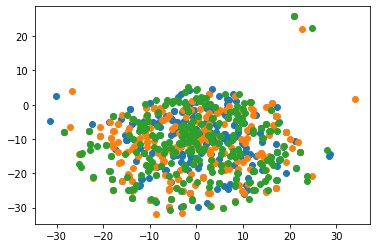

In [9]:
# print out the results to see if it makes sense now
for instance_activation in activations_tsne_embedding_reshaped[:3]:
#     print(instance_activation)
    # make a scatter plot
    # assuming 2d activation array
    plt.scatter(instance_activation[:,0],instance_activation[:,1])

Below: temp code to figure out what's wrong with that caused the circle.

In [118]:
sample_activations = np.concatenate((combined_activations[:100],combined_activations[-100:]),axis=0)

In [119]:
sample_activations.shape

(200, 256, 1024)

In [120]:
# suspect that the issue is with normalization
# normalized_sample_activations=[]
# for activation_image in sample_activations:
#     new_activation = (activation_image - activation_image.min()) / (activation_image.max() - activation_image.min())
#     normalized_sample_activations.append(new_activation)
# normalized_sample_activations = np.array(normalized_sample_activations)

# sampled_activations_2d = np.reshape(normalized_sample_activations,(200*256,1024))
# sample_activations_tsne_embedding = TSNE(n_components=2).fit_transform(sampled_activations_2d)
# sample_activations_tsne_embedding_reshaped = np.reshape(sample_activations_tsne_embedding,(200,256,2))

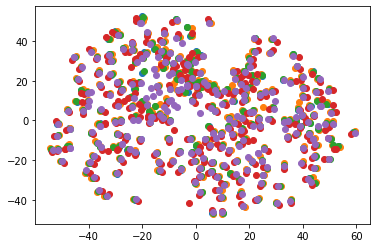

In [126]:
# print out the results to see if it makes sense now
for instance_activation in sample_activations_tsne_embedding_reshaped[:5]:
#     print(instance_activation)
    # make a scatter plot
    # assuming 2d activation array
    plt.scatter(instance_activation[:,0],instance_activation[:,1])

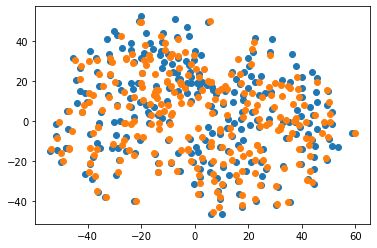

In [128]:
plt.scatter(sample_activations_tsne_embedding_reshaped[0,:,0],sample_activations_tsne_embedding_reshaped[0,:,1])
plt.scatter(sample_activations_tsne_embedding_reshaped[101,:,0],sample_activations_tsne_embedding_reshaped[101,:,1])

In [94]:
sampled_activations

array([[ -556.0492  ,  -602.5747  ,  -424.62024 , ...,    39.036957,
         -731.3852  ,  -486.3531  ],
       [ -104.57867 ,  -286.33374 ,  -235.37236 , ...,  -541.769   ,
         -893.2318  ,  -570.4825  ],
       [ -136.35637 ,  -104.01051 ,   161.6407  , ...,  -381.4917  ,
         -434.03223 ,  -628.8579  ],
       ...,
       [ -476.26553 ,  -760.37787 , -1364.9456  , ...,  -800.61035 ,
        -1341.7526  , -1128.8853  ],
       [ -121.971306,  -139.31151 ,  -290.45343 , ...,  -274.46112 ,
         -636.5187  ,  -357.0703  ],
       [ -769.9349  ,  -878.16754 ,  -792.1358  , ...,  -353.1262  ,
         -711.62427 ,  -429.64462 ]], dtype=float32)

In [10]:
with open('activations_tsne_embeddings_discrete_middle_5.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(activations_tsne_embedding_reshaped, file)

In [144]:
activations_tsne_embedding_reshaped.shape

(1000, 256, 2)

In [19]:
df_full.drop(columns=["bottleneck_activations_embedding"])

,id,name,dataset,image_path,label_path,prediction_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,...,meaningful_tsne_2,pca_1,pca_2,overall_iou,other_iou,road_iou,sidewalk_iou,vegetation_iou,sky_iou,car_iou
0,0,14.jpeg,Cityscapes,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_sample\14.jpeg,dataset\cityscapes_predictions\14.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.483337,0.268173,0.380219,...,2.037380,2151.868066,-6784.818953,0.880295,0.719708,0.944721,0.695616,0.718850,0.862466,0.311558
1,1,87.jpeg,Cityscapes,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_sample\87.jpeg,dataset\cityscapes_predictions\87.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.518250,0.390427,0.322311,...,-14.335748,5757.674332,769.960507,0.905487,0.788071,0.962711,0.000000,0.739955,0.164607,0.863164
2,2,189.jpeg,Cityscapes,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_sample\189.jpeg,dataset\cityscapes_predictions\189.jpeg,dataset\SYNTHIA_256\image\0004751.png,0.679016,0.615875,0.264603,...,-28.158758,6453.862370,-1707.970197,0.849472,0.780169,0.925425,0.127430,0.278427,0.892169,0.811478
3,3,167.jpeg,Cityscapes,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_sample\167.jpeg,dataset\cityscapes_predictions\167.jpeg,dataset\SYNTHIA_256\image\0003061.png,0.516190,0.235931,0.296295,...,-1.028680,-1342.652149,-1318.782118,0.691772,0.462270,0.940231,0.192641,0.402005,0.920625,0.008711
4,4,439.jpeg,Cityscapes,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_sample\439.jpeg,dataset\cityscapes_predictions\439.jpeg,dataset\SYNTHIA_256\image\0004747.png,0.559937,0.501968,0.312622,...,12.353762,1053.077618,-12544.593860,0.738602,0.669778,0.695943,0.133251,0.536060,0.000000,0.033378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0005718.png,Synthia,dataset\SYNTHIA_256\image\0005718.png,dataset\SYNTHIA_256\new_labels\0005718.png,dataset\SYNTHIA_256\predictions\0005718.png,dataset\original_cityscapes_inputs\448.jpeg,0.397522,0.351456,0.180450,...,33.746552,-15917.972410,-5814.941003,0.446594,0.412918,0.185460,0.118750,0.395880,0.242913,0.000000
996,996,0000233.png,Synthia,dataset\SYNTHIA_256\image\0000233.png,dataset\SYNTHIA_256\new_labels\0000233.png,dataset\SYNTHIA_256\predictions\0000233.png,dataset\original_cityscapes_inputs\381.jpeg,0.501556,0.398010,0.180542,...,-10.951044,24858.931930,2629.156672,0.555588,0.397324,0.469250,0.285348,0.302796,0.480744,0.000000
997,997,0007887.png,Synthia,dataset\SYNTHIA_256\image\0007887.png,dataset\SYNTHIA_256\new_labels\0007887.png,dataset\SYNTHIA_256\predictions\0007887.png,dataset\original_cityscapes_inputs\61.jpeg,0.503677,0.353653,0.224991,...,-8.399841,19887.415080,4798.350031,0.449402,0.396668,0.367760,0.095083,0.113190,0.382071,0.000247
998,998,0003190.png,Synthia,dataset\SYNTHIA_256\image\0003190.png,dataset\SYNTHIA_256\new_labels\0003190.png,dataset\SYNTHIA_256\predictions\0003190.png,dataset\original_cityscapes_inputs\61.jpeg,0.456497,0.372055,0.054092,...,22.319105,1392.244554,-15622.588750,0.429291,0.494819,0.050462,0.143641,0.450944,0.148331,0.002307


In [20]:
df_full["bottleneck_activations_embedding"] = activations_tsne_embedding_reshaped.tolist()

In [145]:
# activation_df
df_full["bottleneck_activations_embedding"] = activations_tsne_embedding_reshaped.tolist()

# overall_iou
df_full["overall_iou"] = combined_overall_iou

# iou by class
iou_class_df = pd.DataFrame(combined_iou_by_class,columns = ["other_iou","road_iou","sidewalk_iou","vegetation_iou","sky_iou","car_iou"])
df_full = pd.concat((df_full,iou_class_df),axis=1)

In [146]:
df_full["prediction_path"] = prediction_paths

In [21]:
df_rearrange = df_full[['name','dataset', 'image_path', 'label_path','prediction_path', 'similar_image_paths','similar_IoU_score', 
                       'other_ratio', 'road_ratio', 'sidewalk_ratio','vegetation_ratio', 'sky_ratio', 'car_ratio', 
                       'simple_tsne_1','simple_tsne_2', 'meaningful_tsne_1', 'meaningful_tsne_2',"pca_1","pca_2",
       'bottleneck_activations_embedding', 'overall_iou', 'other_iou',
       'road_iou', 'sidewalk_iou', 'vegetation_iou', 'sky_iou', 'car_iou']]

In [22]:
df_rearrange.columns

Index(['name', 'dataset', 'image_path', 'label_path', 'prediction_path',
       'similar_image_paths', 'similar_IoU_score', 'other_ratio', 'road_ratio',
       'sidewalk_ratio', 'vegetation_ratio', 'sky_ratio', 'car_ratio',
       'simple_tsne_1', 'simple_tsne_2', 'meaningful_tsne_1',
       'meaningful_tsne_2', 'pca_1', 'pca_2',
       'bottleneck_activations_embedding', 'overall_iou', 'other_iou',
       'road_iou', 'sidewalk_iou', 'vegetation_iou', 'sky_iou', 'car_iou'],
      dtype='object')

In [23]:
len(df_rearrange.columns)

27

In [24]:
df_rearrange

,name,dataset,image_path,label_path,prediction_path,similar_image_paths,similar_IoU_score,other_ratio,road_ratio,sidewalk_ratio,...,pca_1,pca_2,bottleneck_activations_embedding,overall_iou,other_iou,road_iou,sidewalk_iou,vegetation_iou,sky_iou,car_iou
0,14.jpeg,Cityscapes,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_sample\14.jpeg,dataset\cityscapes_predictions\14.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.483337,0.268173,0.380219,0.054855,...,2151.868066,-6784.818953,"[[8.872200965881348, -6.868399143218994], [19....",0.880295,0.719708,0.944721,0.695616,0.718850,0.862466,0.311558
1,87.jpeg,Cityscapes,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_sample\87.jpeg,dataset\cityscapes_predictions\87.jpeg,dataset\SYNTHIA_256\image\0004332.png,0.518250,0.390427,0.322311,0.000000,...,5757.674332,769.960507,"[[-13.801664352416992, -22.382137298583984], [...",0.905487,0.788071,0.962711,0.000000,0.739955,0.164607,0.863164
2,189.jpeg,Cityscapes,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_sample\189.jpeg,dataset\cityscapes_predictions\189.jpeg,dataset\SYNTHIA_256\image\0004751.png,0.679016,0.615875,0.264603,0.010590,...,6453.862370,-1707.970197,"[[12.262382507324219, -19.361568450927734], [1...",0.849472,0.780169,0.925425,0.127430,0.278427,0.892169,0.811478
3,167.jpeg,Cityscapes,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_sample\167.jpeg,dataset\cityscapes_predictions\167.jpeg,dataset\SYNTHIA_256\image\0003061.png,0.516190,0.235931,0.296295,0.021698,...,-1342.652149,-1318.782118,"[[12.213105201721191, -4.823805332183838], [3....",0.691772,0.462270,0.940231,0.192641,0.402005,0.920625,0.008711
4,439.jpeg,Cityscapes,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_sample\439.jpeg,dataset\cityscapes_predictions\439.jpeg,dataset\SYNTHIA_256\image\0004747.png,0.559937,0.501968,0.312622,0.026047,...,1053.077618,-12544.593860,"[[-14.420482635498047, -20.695220947265625], [...",0.738602,0.669778,0.695943,0.133251,0.536060,0.000000,0.033378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0005718.png,Synthia,dataset\SYNTHIA_256\image\0005718.png,dataset\SYNTHIA_256\new_labels\0005718.png,dataset\SYNTHIA_256\predictions\0005718.png,dataset\original_cityscapes_inputs\448.jpeg,0.397522,0.351456,0.180450,0.205688,...,-15917.972410,-5814.941003,"[[-8.2290678024292, 20.19437599182129], [-14.2...",0.446594,0.412918,0.185460,0.118750,0.395880,0.242913,0.000000
996,0000233.png,Synthia,dataset\SYNTHIA_256\image\0000233.png,dataset\SYNTHIA_256\new_labels\0000233.png,dataset\SYNTHIA_256\predictions\0000233.png,dataset\original_cityscapes_inputs\381.jpeg,0.501556,0.398010,0.180542,0.051147,...,24858.931930,2629.156672,"[[-8.302085876464844, 20.149219512939453], [-1...",0.555588,0.397324,0.469250,0.285348,0.302796,0.480744,0.000000
997,0007887.png,Synthia,dataset\SYNTHIA_256\image\0007887.png,dataset\SYNTHIA_256\new_labels\0007887.png,dataset\SYNTHIA_256\predictions\0007887.png,dataset\original_cityscapes_inputs\61.jpeg,0.503677,0.353653,0.224991,0.224442,...,19887.415080,4798.350031,"[[-7.1908135414123535, 19.719547271728516], [-...",0.449402,0.396668,0.367760,0.095083,0.113190,0.382071,0.000247
998,0003190.png,Synthia,dataset\SYNTHIA_256\image\0003190.png,dataset\SYNTHIA_256\new_labels\0003190.png,dataset\SYNTHIA_256\predictions\0003190.png,dataset\original_cityscapes_inputs\61.jpeg,0.456497,0.372055,0.054092,0.430496,...,1392.244554,-15622.588750,"[[-8.125761032104492, 19.964284896850586], [-1...",0.429291,0.494819,0.050462,0.143641,0.450944,0.148331,0.002307


In [25]:
df_rearrange.to_csv("system_df_v3.csv",index=True)